In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 랜덤 시드 고정
np.random.seed(42)

# 가상 데이터 생성 (고객 500명, 주문 1000건)
n_orders = 1000
n_users = 500

data = {
    'order_id': np.arange(n_orders),
    'user_id': np.random.randint(1, n_users + 1, n_orders),
    'amount': np.random.randint(10000, 100000, n_orders),
    # 2023년 1월 ~ 12월 사이의 날짜 생성
    'date': pd.to_datetime('2023-01-01') + pd.to_timedelta(np.random.randint(0, 365, n_orders), unit='D')
}

df = pd.DataFrame(data)
df['user_id'] = 'User_' + df['user_id'].astype(str)

print(f"✅ 데이터 생성 완료: {df.shape}")
df.head()

✅ 데이터 생성 완료: (1000, 4)


,order_id,user_id,amount,date
0,0,User_103,72292,2023-03-13
1,1,User_436,33833,2023-03-01
2,2,User_349,14158,2023-05-25
3,3,User_271,72680,2023-04-03
4,4,User_107,30309,2023-11-05


In [3]:
df['order_month'] = df['date'].dt.to_period('M').dt.to_timestamp()

df['cohort_month'] = df.groupby('user_id')['order_month'].transform('min')

print("--- 코호트 할당 결과 ---")
print(df[['user_id', 'order_month', 'cohort_month']].head())

--- 코호트 할당 결과 ---
    user_id order_month cohort_month
0  User_103  2023-03-01   2023-01-01
1  User_436  2023-03-01   2023-03-01
2  User_349  2023-05-01   2023-02-01
3  User_271  2023-04-01   2023-01-01
4  User_107  2023-11-01   2023-11-01


In [4]:
# 1. 연도와 월 차이 계산
year_diff = df['order_month'].dt.year - df['cohort_month'].dt.year
month_diff = df['order_month'].dt.month - df['cohort_month'].dt.month

# 2. 총 개월 수 차이 (Cohort Index)
df['cohort_index'] = (year_diff * 12) + month_diff + 1

print("--- 개월 수 계산 결과 ---")
print(df[['user_id', 'order_month', 'cohort_month', 'cohort_index']].head())

--- 개월 수 계산 결과 ---
    user_id order_month cohort_month  cohort_index
0  User_103  2023-03-01   2023-01-01             3
1  User_436  2023-03-01   2023-03-01             1
2  User_349  2023-05-01   2023-02-01             4
3  User_271  2023-04-01   2023-01-01             4
4  User_107  2023-11-01   2023-11-01             1


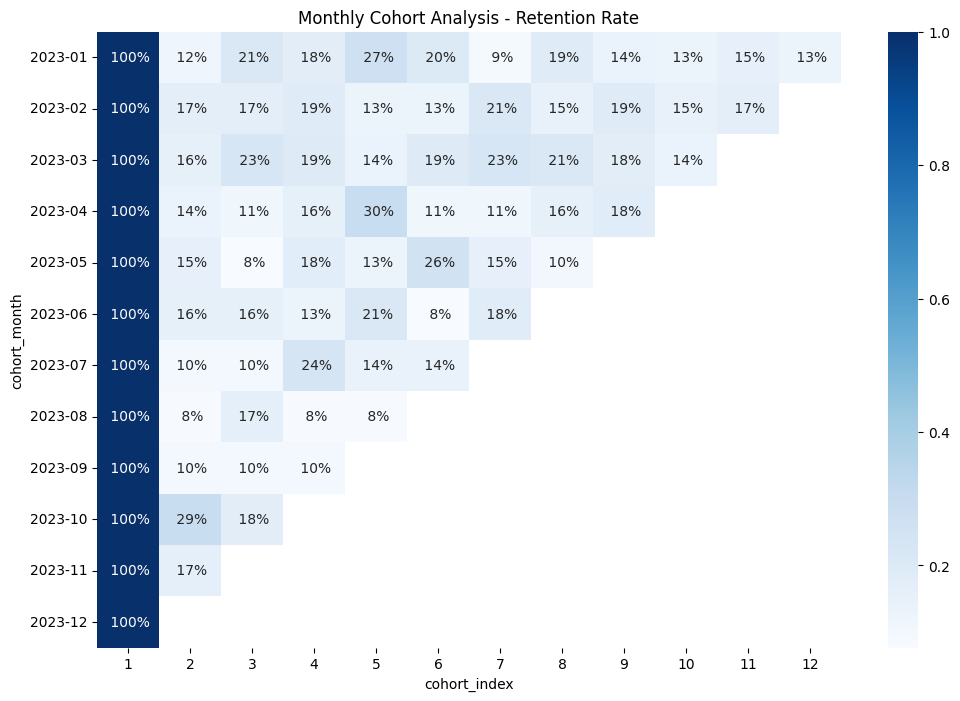

In [10]:
# 1. 피벗 테이블 생성 (월별 고유 방문자 수 카운트)
cohort_data = df.pivot_table(
    index = 'cohort_month',
    columns = 'cohort_index',
    values = 'user_id',
    aggfunc = 'nunique'  # 고유 유저 수 (중복 제거)
)
# 2. 잔존율(Retention Rate)로 변환
# 첫 달(index 1)의 방문자 수로 모든 컬럼을 나눔
cohort_size = cohort_data.iloc[:, 0] # 첫 번째 열(가입 당월 인원)
retention = cohort_data.divide(cohort_size, axis=0) # 나누기

# 3. 히트맵 그리기
plt.figure(figsize=(12, 8))
# y축 라벨 보기 좋게 변경 (2023-01-01 -> 2023-01)
yticklabels = retention.index.strftime('%Y-%m')

sns.heatmap(data=retention,
            annot=True,   # 숫자 표시
            fmt=' .0%',   # 퍼센트 형식
            cmap='Blues', # 파란색 계열
            yticklabels=yticklabels)

plt.title('Monthly Cohort Analysis - Retention Rate')
plt.show()

In [11]:
import pandas as pd

# 1. 회원 정보 (User Table)
users = pd.DataFrame({
    'user_id': ['User_A', 'User_B', 'User_C', 'User_D'],
    'name': ['철수', '영희', '민수', '지수'],
    'city': ['서울', '부산', '서울', '대구']
})

# 2. 주문 정보 (Order Table)
orders = pd.DataFrame({
    'order_id': ['O01', 'O02', 'O03', 'O04', 'O05'],
    'user_id': ['User_A', 'User_B', 'User_A', 'User_E', 'User_B'], # User_E(비회원) 존재
    'amount': [50000, 30000, 10000, 20000, 100000]
})

print("--- 🙋‍♂️ 회원 테이블 (Users) ---")
print(users)
print("\n--- 🛍️ 주문 테이블 (Orders) ---")
print(orders)

--- 🙋‍♂️ 회원 테이블 (Users) ---
  user_id name city
0  User_A   철수   서울
1  User_B   영희   부산
2  User_C   민수   서울
3  User_D   지수   대구

--- 🛍️ 주문 테이블 (Orders) ---
  order_id user_id  amount
0      O01  User_A   50000
1      O02  User_B   30000
2      O03  User_A   10000
3      O04  User_E   20000
4      O05  User_B  100000


In [12]:
# SQL: SELECT * FROM orders LEFT JOIN users ON orders.user_id = users.user_id
# Pandas:
merged_df = pd.merge(orders, users, on='user_id', how='left')
print("--- 🔗 합쳐진 데이터 (Merged) ---")
print(merged_df)

--- 🔗 합쳐진 데이터 (Merged) ---
  order_id user_id  amount name city
0      O01  User_A   50000   철수   서울
1      O02  User_B   30000   영희   부산
2      O03  User_A   10000   철수   서울
3      O04  User_E   20000  NaN  NaN
4      O05  User_B  100000   영희   부산


In [13]:
city_sales = merged_df.groupby('city')['amount'].sum()
print(city_sales)

city
부산    130000
서울     60000
Name: amount, dtype: int64
